In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('daily-maximum-temperatures-in-me.csv')

In [3]:
df.head()

,date,max_temp
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5
3,1981-01-04,20.7
4,1981-01-05,21.5


In [4]:
raw_data = df.max_temp.values

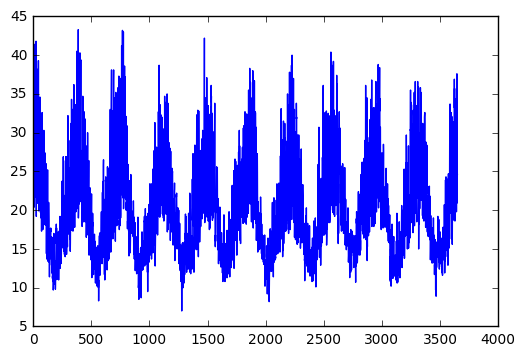

In [5]:
plt.plot(raw_data)

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
raw_data = scaler.fit_transform(raw_data.reshape(-1,1))

In [7]:
len(raw_data)

3650

In [8]:
timestep = 5
X = []
Y = []
for i in range(len(raw_data)-(timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])

In [9]:
X = np.asanyarray(X)
X = X.reshape((X.shape[0],X.shape[1],1))

In [10]:
Y = np.asanyarray(Y)

In [11]:
len(Y)

3645

In [12]:
k = int(0.7*len(Y))
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]

In [13]:
Ytrain = Y[:k]
Ytest = Y[k:]

In [14]:
model = Sequential()
model.add(LSTM(64,batch_input_shape=(None,timestep,1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 64)             16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(Xtrain,
          Ytrain,
          batch_size=20,
          validation_data=(Xtest,Ytest),
          verbose=2,
          epochs=30,
          shuffle=False)

Train on 2551 samples, validate on 1094 samples
Epoch 1/30
3s - loss: 0.0266 - val_loss: 0.0226
Epoch 2/30
2s - loss: 0.0185 - val_loss: 0.0217
Epoch 3/30
2s - loss: 0.0180 - val_loss: 0.0237
Epoch 4/30
2s - loss: 0.0176 - val_loss: 0.0216
Epoch 5/30
2s - loss: 0.0167 - val_loss: 0.0209
Epoch 6/30
2s - loss: 0.0165 - val_loss: 0.0179
Epoch 7/30
2s - loss: 0.0160 - val_loss: 0.0158
Epoch 8/30
2s - loss: 0.0157 - val_loss: 0.0163
Epoch 9/30
3s - loss: 0.0149 - val_loss: 0.0157
Epoch 10/30
2s - loss: 0.0143 - val_loss: 0.0150
Epoch 11/30
2s - loss: 0.0145 - val_loss: 0.0144
Epoch 12/30
2s - loss: 0.0141 - val_loss: 0.0138
Epoch 13/30
2s - loss: 0.0140 - val_loss: 0.0138
Epoch 14/30
3s - loss: 0.0138 - val_loss: 0.0148
Epoch 15/30
3s - loss: 0.0139 - val_loss: 0.0139
Epoch 16/30
2s - loss: 0.0137 - val_loss: 0.0134
Epoch 17/30
2s - loss: 0.0136 - val_loss: 0.0132
Epoch 18/30
2s - loss: 0.0136 - val_loss: 0.0132
Epoch 19/30
3s - loss: 0.0133 - val_loss: 0.0129
Epoch 20/30
3s - loss: 0.0135 

In [17]:
random_pos = random.randint(0,len(Ytest)-100)

Plotting Results


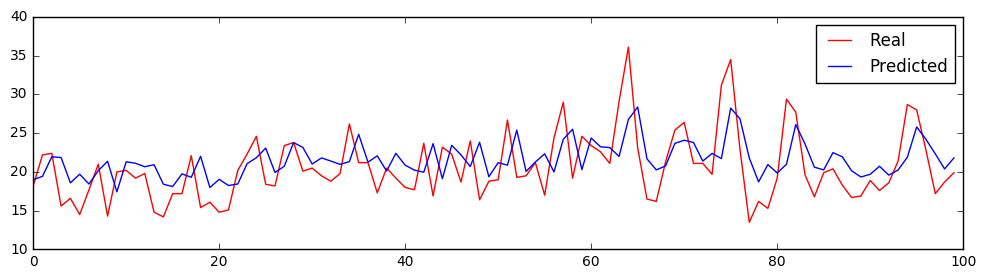

In [20]:
selected_input = Xtest[random_pos:random_pos+100,:,:]
real_output = scaler.inverse_transform(Ytest[random_pos:random_pos+100])
predicted_output = model.predict(selected_input, batch_size=1)
predicted_output = scaler.inverse_transform(predicted_output)
print('Plotting Results')
plt.figure(figsize=(12,3))
xpos = range(len(predicted_output))
plt.plot(xpos,real_output,'r',xpos,predicted_output,'b')
plt.legend(('Real','Predicted','Forcasted'))
plt.savefig('out.jpg',dpi=400)
plt.show()